In [190]:
# Import libaries
import glob
import urllib.request
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

In [268]:
# Utility functions

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    return img


def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for box in bboxes:
        cv2.rectangle(draw_img, box[0], box[1], color, thick)
    return draw_img
        
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image

    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return features

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    bbox_list = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        bbox_list.extend(bbox)
    # Return the image
    return img, bbox_list



In [192]:
# Read image files

def get_sampled_image(source_dir, image_type, num_samples):
    raw_images = np.array([])

    vehicle_image_dirs = glob.glob('{}/*'.format(source_dir))
    for vd in vehicle_image_dirs:
        local_images = glob.glob("{}/*.{}".format(vd, image_type))
        samples = np.random.choice(local_images, num_samples)
        raw_images = np.append(raw_images, samples)
        
    return raw_images

vehicles = get_sampled_image("vehicles", "png", 800)
non_vehicles = get_sampled_image("non-vehicles", "png", 2000)



In [193]:
# Global params
spatial_size=(32, 32)
hist_bins=32
orient=9
pix_per_cell=8
cell_per_block=2
hog_channel='ALL'
spatial_feat=True
hist_feat=True
hog_feat=True

In [194]:
# Generating features

cars = extract_features(vehicles, color_space='RGB', spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
non_cars = extract_features(non_vehicles, color_space='RGB', spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)    
X = np.vstack((cars, non_cars)).astype(np.float64)
y = np.hstack((np.ones(len(cars)), np.zeros(len(non_cars))))


In [195]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

In [196]:
# Train the model

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = SVC()
clf = GridSearchCV(svr, parameters)
%time clf.fit(X_train, y_train)
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))


CPU times: user 25min 15s, sys: 28.3 s, total: 25min 44s
Wall time: 27min 39s
Test Accuracy of SVC =  0.9975


In [197]:
# Save the model

obj = [clf, X_scaler]
with open("object.pkl", 'wb') as f:
    pickle.dump(obj, f)
    


In [198]:
# Load the model

clf_p = {}
X_scaler_p = {}
with open("object.pkl", 'rb') as f:
    obj = pickle.load(f)
    clf_p = obj[0]
    X_scaler_p = obj[1]

CPU times: user 1.2 ms, sys: 858 µs, total: 2.06 ms
Wall time: 2.08 ms


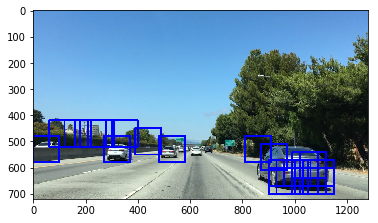

In [269]:
# Feed the model to sliding window

image = mpimg.imread("bbox-example-image.jpg")
# image = mpimg.imread("frame.jpg")
second_image = np.copy(image)
draw_image = np.copy(image)

image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[360, 720], 
                    xy_window=(100, 100), xy_overlap=(0.7, 0.7))

hot_windows = search_windows(image, windows, clf, X_scaler, color_space="RGB", 
                        spatial_size=(32, 32), hist_bins=32, 
                        orient=9, pix_per_cell=8, 
                        cell_per_block=2, 
                        hog_channel='ALL', spatial_feat=True, 
                        hist_feat=True, hog_feat=True)  

%time window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

plt.imshow(window_img)


In [263]:
# Define a single function that can extract features using hog sub-sampling and make predictions
# def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, windows_size, cells_per_step):
def find_cars(img, ystart, ystop, scale, cells_per_step, ws, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
  
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    box_list = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
#     cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for windows_size in ws:        
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+windows_size, xleft:xleft+windows_size], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(windows_size*scale)
                    box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                    
    return draw_img, box_list


CPU times: user 21.8 s, sys: 268 ms, total: 22 s
Wall time: 22.7 s


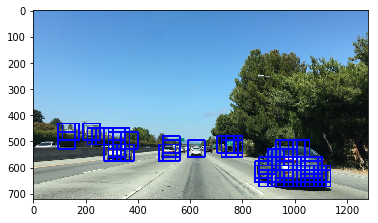

In [264]:
ws = [64]

ystart = 400
ystop = 680
scale = 1
cells_per_step = 2

%time out_img, box_list = find_cars(second_image, ystart, ystop, scale, cells_per_step, ws, clf, X_scaler, 9, 8, 2, (32, 32), 32)

plt.imshow(out_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


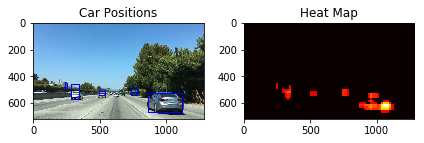

In [273]:
# heatmap to filter out false positives

heat = np.zeros_like(image[:,:,0]).astype(np.float)
heat = add_heat(heat, box_list)
heat = apply_threshold(heat,3)
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
draw_img, bbox = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [12]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [256]:

def process_image(image):
    ws = [64]

    ystart = 400
    ystop = 680
    scale = 1
    cells_per_step = 2

    out_img, box_list = find_cars(image, ystart, ystop, scale, cells_per_step, ws, clf, X_scaler, 9, 8, 2, (32, 32), 32)

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, box_list)
    heat = apply_threshold(heat,3)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    result, bbox = draw_labeled_bboxes(np.copy(image), labels)
#     result = draw_boxes(result, prev_bbox)
#     prev_bbox = bbox

    return result

In [260]:
prev_bbox = []
white_output = 'video_output/vehicle_detection.mp4'
# clip1 = VideoFileClip("project_video.mp4").subclip(7,10)
# clip1.save_frame("frame.jpg")
clip1 = VideoFileClip("project_video.mp4")

# white_clip = clip1.fl_image(lambda image: process_image(image, prev_bbox))
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video video_output/vehicle_detection.mp4
[MoviePy] Writing video video_output/vehicle_detection.mp4











  0%|          | 0/1261 [00:00<?, ?it/s]








  0%|          | 1/1261 [00:24<8:35:12, 24.53s/it]








  0%|          | 2/1261 [00:54<9:32:03, 27.26s/it]








  0%|          | 3/1261 [01:19<9:14:42, 26.46s/it]








  0%|          | 4/1261 [01:44<9:07:08, 26.12s/it]








  0%|          | 5/1261 [02:09<9:02:19, 25.91s/it]








  0%|          | 6/1261 [02:32<8:53:10, 25.49s/it]








  1%|          | 7/1261 [02:58<8:53:03, 25.50s/it]








  1%|          | 8/1261 [03:27<9:01:38, 25.94s/it]








  1%|          | 9/1261 [03:50<8:55:19, 25.65s/it]








  1%|          | 10/1261 [04:18<8:58:50, 25.84s/it]








  1%|          | 11/1261 [04:41<8:53:31, 25.61s/it]








  1%|          | 12/1261 [05:03<8:46:54, 25.31s/it]








  1%|          | 13/1261 [05:24<8:39:45, 24.99s/it]








  1%|          | 14/1261 [05:47<8:35:46, 24.82s/it]








  1%|          | 15/1261 [06:09<8:31:55, 24.65s/it]








  1%|▏         | 16/1261 [06:32<8:29:33, 24.56s/it]

  7%|▋         | 94/1261 [37:52<7:50:10, 24.17s/it]








  8%|▊         | 95/1261 [38:16<7:49:49, 24.18s/it]








  8%|▊         | 96/1261 [38:39<7:49:12, 24.17s/it]








  8%|▊         | 97/1261 [39:03<7:48:39, 24.16s/it]








  8%|▊         | 98/1261 [39:25<7:47:55, 24.14s/it]








  8%|▊         | 99/1261 [39:53<7:48:14, 24.18s/it]








  8%|▊         | 100/1261 [40:25<7:49:15, 24.25s/it]








  8%|▊         | 101/1261 [40:52<7:49:28, 24.28s/it]








  8%|▊         | 102/1261 [41:14<7:48:40, 24.26s/it]








  8%|▊         | 103/1261 [41:36<7:47:47, 24.24s/it]








  8%|▊         | 104/1261 [42:02<7:47:42, 24.25s/it]








  8%|▊         | 105/1261 [42:24<7:46:58, 24.24s/it]








  8%|▊         | 106/1261 [42:46<7:46:04, 24.21s/it]








  8%|▊         | 107/1261 [43:09<7:45:27, 24.20s/it]








  9%|▊         | 108/1261 [43:31<7:44:40, 24.18s/it]








  9%|▊         | 109/1261 [43:54<7:44:02, 24.17s/it]








  9%|▊         | 110/1261 [44:

 15%|█▍        | 186/1261 [1:12:07<6:56:48, 23.26s/it]








 15%|█▍        | 187/1261 [1:12:28<6:56:15, 23.25s/it]








 15%|█▍        | 188/1261 [1:12:49<6:55:39, 23.24s/it]








 15%|█▍        | 189/1261 [1:13:10<6:55:03, 23.23s/it]








 15%|█▌        | 190/1261 [1:13:34<6:54:44, 23.23s/it]








 15%|█▌        | 191/1261 [1:13:57<6:54:21, 23.24s/it]








 15%|█▌        | 192/1261 [1:14:23<6:54:13, 23.25s/it]








 15%|█▌        | 193/1261 [1:14:48<6:53:55, 23.25s/it]








 15%|█▌        | 194/1261 [1:15:10<6:53:27, 23.25s/it]








 15%|█▌        | 195/1261 [1:15:34<6:53:09, 23.25s/it]








 16%|█▌        | 196/1261 [1:15:59<6:52:53, 23.26s/it]








 16%|█▌        | 197/1261 [1:16:21<6:52:26, 23.26s/it]








 16%|█▌        | 198/1261 [1:16:45<6:52:06, 23.26s/it]








 16%|█▌        | 199/1261 [1:17:09<6:51:45, 23.26s/it]








 16%|█▌        | 200/1261 [1:17:30<6:51:11, 23.25s/it]








 16%|█▌        | 201/1261 [1:17:51<6:50:34, 23.24s/it]


 22%|██▏       | 277/1261 [1:45:55<6:16:16, 22.94s/it]








 22%|██▏       | 278/1261 [1:46:16<6:15:45, 22.94s/it]








 22%|██▏       | 279/1261 [1:46:36<6:15:14, 22.93s/it]








 22%|██▏       | 280/1261 [1:46:57<6:14:42, 22.92s/it]








 22%|██▏       | 281/1261 [1:47:17<6:14:11, 22.91s/it]








 22%|██▏       | 282/1261 [1:47:38<6:13:40, 22.90s/it]








 22%|██▏       | 283/1261 [1:47:58<6:13:09, 22.89s/it]








 23%|██▎       | 284/1261 [1:48:19<6:12:39, 22.89s/it]








 23%|██▎       | 285/1261 [1:48:40<6:12:09, 22.88s/it]








 23%|██▎       | 286/1261 [1:49:00<6:11:38, 22.87s/it]








 23%|██▎       | 287/1261 [1:49:21<6:11:07, 22.86s/it]








 23%|██▎       | 288/1261 [1:49:41<6:10:36, 22.85s/it]








 23%|██▎       | 289/1261 [1:50:02<6:10:06, 22.85s/it]








 23%|██▎       | 290/1261 [1:50:23<6:09:36, 22.84s/it]








 23%|██▎       | 291/1261 [1:50:44<6:09:07, 22.83s/it]








 23%|██▎       | 292/1261 [1:51:05<6:08:39, 22.83s/it]


 29%|██▉       | 368/1261 [2:17:42<5:34:10, 22.45s/it]








 29%|██▉       | 369/1261 [2:18:05<5:33:49, 22.46s/it]








 29%|██▉       | 370/1261 [2:18:29<5:33:31, 22.46s/it]








 29%|██▉       | 371/1261 [2:18:51<5:33:05, 22.46s/it]








 30%|██▉       | 372/1261 [2:19:12<5:32:39, 22.45s/it]








 30%|██▉       | 373/1261 [2:19:32<5:32:12, 22.45s/it]








 30%|██▉       | 374/1261 [2:19:54<5:31:48, 22.44s/it]








 30%|██▉       | 375/1261 [2:20:14<5:31:21, 22.44s/it]








 30%|██▉       | 376/1261 [2:20:35<5:30:54, 22.43s/it]








 30%|██▉       | 377/1261 [2:20:55<5:30:27, 22.43s/it]








 30%|██▉       | 378/1261 [2:21:16<5:30:00, 22.42s/it]








 30%|███       | 379/1261 [2:21:36<5:29:33, 22.42s/it]








 30%|███       | 380/1261 [2:21:57<5:29:06, 22.41s/it]








 30%|███       | 381/1261 [2:22:17<5:28:39, 22.41s/it]








 30%|███       | 382/1261 [2:22:38<5:28:12, 22.40s/it]








 30%|███       | 383/1261 [2:22:58<5:27:45, 22.40s/it]


 36%|███▋      | 459/1261 [2:48:39<4:54:40, 22.05s/it]








 36%|███▋      | 460/1261 [2:48:59<4:54:15, 22.04s/it]








 37%|███▋      | 461/1261 [2:49:19<4:53:50, 22.04s/it]








 37%|███▋      | 462/1261 [2:49:39<4:53:24, 22.03s/it]








 37%|███▋      | 463/1261 [2:49:59<4:52:59, 22.03s/it]








 37%|███▋      | 464/1261 [2:50:19<4:52:34, 22.03s/it]








 37%|███▋      | 465/1261 [2:50:39<4:52:08, 22.02s/it]








 37%|███▋      | 466/1261 [2:51:00<4:51:44, 22.02s/it]








 37%|███▋      | 467/1261 [2:51:20<4:51:19, 22.01s/it]








 37%|███▋      | 468/1261 [2:51:40<4:50:53, 22.01s/it]








 37%|███▋      | 469/1261 [2:52:00<4:50:28, 22.01s/it]








 37%|███▋      | 470/1261 [2:52:20<4:50:03, 22.00s/it]








 37%|███▋      | 471/1261 [2:52:40<4:49:38, 22.00s/it]








 37%|███▋      | 472/1261 [2:53:01<4:49:13, 21.99s/it]








 38%|███▊      | 473/1261 [2:53:21<4:48:48, 21.99s/it]








 38%|███▊      | 474/1261 [2:53:41<4:48:22, 21.99s/it]


 44%|████▎     | 550/1261 [3:19:08<4:17:26, 21.72s/it]








 44%|████▎     | 551/1261 [3:19:28<4:17:02, 21.72s/it]








 44%|████▍     | 552/1261 [3:19:48<4:16:38, 21.72s/it]








 44%|████▍     | 553/1261 [3:20:08<4:16:14, 21.72s/it]








 44%|████▍     | 554/1261 [3:20:28<4:15:50, 21.71s/it]








 44%|████▍     | 555/1261 [3:20:49<4:15:27, 21.71s/it]








 44%|████▍     | 556/1261 [3:21:09<4:15:03, 21.71s/it]








 44%|████▍     | 557/1261 [3:21:29<4:14:39, 21.70s/it]








 44%|████▍     | 558/1261 [3:21:49<4:14:15, 21.70s/it]








 44%|████▍     | 559/1261 [3:22:09<4:13:52, 21.70s/it]








 44%|████▍     | 560/1261 [3:22:29<4:13:28, 21.70s/it]








 44%|████▍     | 561/1261 [3:22:49<4:13:04, 21.69s/it]








 45%|████▍     | 562/1261 [3:23:09<4:12:41, 21.69s/it]








 45%|████▍     | 563/1261 [3:23:29<4:12:17, 21.69s/it]








 45%|████▍     | 564/1261 [3:23:49<4:11:53, 21.68s/it]








 45%|████▍     | 565/1261 [3:24:09<4:11:29, 21.68s/it]


 51%|█████     | 641/1261 [3:49:37<3:42:05, 21.49s/it]








 51%|█████     | 642/1261 [3:49:57<3:41:43, 21.49s/it]








 51%|█████     | 643/1261 [3:50:17<3:41:20, 21.49s/it]








 51%|█████     | 644/1261 [3:50:37<3:40:57, 21.49s/it]








 51%|█████     | 645/1261 [3:50:57<3:40:34, 21.49s/it]








 51%|█████     | 646/1261 [3:51:17<3:40:11, 21.48s/it]








 51%|█████▏    | 647/1261 [3:51:37<3:39:49, 21.48s/it]








 51%|█████▏    | 648/1261 [3:51:58<3:39:26, 21.48s/it]








 51%|█████▏    | 649/1261 [3:52:18<3:39:03, 21.48s/it]








 52%|█████▏    | 650/1261 [3:52:38<3:38:40, 21.47s/it]








 52%|█████▏    | 651/1261 [3:52:58<3:38:18, 21.47s/it]








 52%|█████▏    | 652/1261 [3:53:18<3:37:55, 21.47s/it]








 52%|█████▏    | 653/1261 [3:53:38<3:37:32, 21.47s/it]








 52%|█████▏    | 654/1261 [3:53:58<3:37:09, 21.47s/it]








 52%|█████▏    | 655/1261 [3:54:18<3:36:47, 21.46s/it]








 52%|█████▏    | 656/1261 [3:54:38<3:36:24, 21.46s/it]


 58%|█████▊    | 732/1261 [4:20:06<3:07:58, 21.32s/it]








 58%|█████▊    | 733/1261 [4:20:26<3:07:36, 21.32s/it]








 58%|█████▊    | 734/1261 [4:20:46<3:07:13, 21.32s/it]








 58%|█████▊    | 735/1261 [4:21:06<3:06:51, 21.31s/it]








 58%|█████▊    | 736/1261 [4:21:26<3:06:29, 21.31s/it]








 58%|█████▊    | 737/1261 [4:21:46<3:06:07, 21.31s/it]








 59%|█████▊    | 738/1261 [4:22:06<3:05:44, 21.31s/it]








 59%|█████▊    | 739/1261 [4:22:26<3:05:22, 21.31s/it]








 59%|█████▊    | 740/1261 [4:22:46<3:05:00, 21.31s/it]








 59%|█████▉    | 741/1261 [4:23:06<3:04:38, 21.30s/it]








 59%|█████▉    | 742/1261 [4:23:26<3:04:16, 21.30s/it]








 59%|█████▉    | 743/1261 [4:23:46<3:03:54, 21.30s/it]








 59%|█████▉    | 744/1261 [4:24:06<3:03:31, 21.30s/it]








 59%|█████▉    | 745/1261 [4:24:27<3:03:09, 21.30s/it]








 59%|█████▉    | 746/1261 [4:24:47<3:02:47, 21.30s/it]








 59%|█████▉    | 747/1261 [4:25:07<3:02:25, 21.29s/it]


 65%|██████▌   | 823/1261 [4:50:35<2:34:39, 21.18s/it]








 65%|██████▌   | 824/1261 [4:50:55<2:34:17, 21.18s/it]








 65%|██████▌   | 825/1261 [4:51:15<2:33:55, 21.18s/it]








 66%|██████▌   | 826/1261 [4:51:35<2:33:33, 21.18s/it]








 66%|██████▌   | 827/1261 [4:51:55<2:33:11, 21.18s/it]








 66%|██████▌   | 828/1261 [4:52:15<2:32:50, 21.18s/it]








 66%|██████▌   | 829/1261 [4:52:35<2:32:28, 21.18s/it]








 66%|██████▌   | 830/1261 [4:52:55<2:32:06, 21.18s/it]








 66%|██████▌   | 831/1261 [4:53:15<2:31:44, 21.17s/it]








 66%|██████▌   | 832/1261 [4:53:35<2:31:23, 21.17s/it]








 66%|██████▌   | 833/1261 [4:53:55<2:31:01, 21.17s/it]








 66%|██████▌   | 834/1261 [4:54:15<2:30:39, 21.17s/it]








 66%|██████▌   | 835/1261 [4:54:35<2:30:17, 21.17s/it]








 66%|██████▋   | 836/1261 [4:54:56<2:29:56, 21.17s/it]








 66%|██████▋   | 837/1261 [4:55:16<2:29:34, 21.17s/it]








 66%|██████▋   | 838/1261 [4:55:36<2:29:12, 21.16s/it]


 72%|███████▏  | 914/1261 [5:21:01<2:01:52, 21.07s/it]








 73%|███████▎  | 915/1261 [5:21:21<2:01:31, 21.07s/it]








 73%|███████▎  | 916/1261 [5:21:41<2:01:09, 21.07s/it]








 73%|███████▎  | 917/1261 [5:22:01<2:00:48, 21.07s/it]








 73%|███████▎  | 918/1261 [5:22:21<2:00:26, 21.07s/it]








 73%|███████▎  | 919/1261 [5:22:41<2:00:05, 21.07s/it]








 73%|███████▎  | 920/1261 [5:23:02<1:59:43, 21.07s/it]








 73%|███████▎  | 921/1261 [5:23:22<1:59:22, 21.07s/it]








 73%|███████▎  | 922/1261 [5:23:42<1:59:01, 21.07s/it]








 73%|███████▎  | 923/1261 [5:24:02<1:58:39, 21.06s/it]








 73%|███████▎  | 924/1261 [5:24:22<1:58:18, 21.06s/it]








 73%|███████▎  | 925/1261 [5:24:43<1:57:57, 21.06s/it]








 73%|███████▎  | 926/1261 [5:25:03<1:57:35, 21.06s/it]








 74%|███████▎  | 927/1261 [5:25:23<1:57:14, 21.06s/it]








 74%|███████▎  | 928/1261 [5:25:43<1:56:52, 21.06s/it]








 74%|███████▎  | 929/1261 [5:26:03<1:56:31, 21.06s/it]


 80%|███████▉  | 1005/1261 [5:51:31<1:29:32, 20.99s/it]








 80%|███████▉  | 1006/1261 [5:51:51<1:29:11, 20.99s/it]








 80%|███████▉  | 1007/1261 [5:52:11<1:28:50, 20.98s/it]








 80%|███████▉  | 1008/1261 [5:52:31<1:28:28, 20.98s/it]








 80%|████████  | 1009/1261 [5:52:51<1:28:07, 20.98s/it]








 80%|████████  | 1010/1261 [5:53:11<1:27:46, 20.98s/it]








 80%|████████  | 1011/1261 [5:53:32<1:27:25, 20.98s/it]








 80%|████████  | 1012/1261 [5:53:52<1:27:04, 20.98s/it]








 80%|████████  | 1013/1261 [5:54:12<1:26:42, 20.98s/it]








 80%|████████  | 1014/1261 [5:54:32<1:26:21, 20.98s/it]








 80%|████████  | 1015/1261 [5:54:52<1:26:00, 20.98s/it]








 81%|████████  | 1016/1261 [5:55:12<1:25:39, 20.98s/it]








 81%|████████  | 1017/1261 [5:55:32<1:25:18, 20.98s/it]








 81%|████████  | 1018/1261 [5:55:52<1:24:56, 20.98s/it]








 81%|████████  | 1019/1261 [5:56:12<1:24:35, 20.97s/it]








 81%|████████  | 1020/1261 [5:56:33<1:24

 87%|████████▋ | 1095/1261 [6:21:39<57:51, 20.91s/it]








 87%|████████▋ | 1096/1261 [6:21:59<57:30, 20.91s/it]








 87%|████████▋ | 1097/1261 [6:22:19<57:09, 20.91s/it]








 87%|████████▋ | 1098/1261 [6:22:39<56:48, 20.91s/it]








 87%|████████▋ | 1099/1261 [6:22:59<56:27, 20.91s/it]








 87%|████████▋ | 1100/1261 [6:23:19<56:06, 20.91s/it]








 87%|████████▋ | 1101/1261 [6:23:39<55:45, 20.91s/it]








 87%|████████▋ | 1102/1261 [6:23:59<55:24, 20.91s/it]








 87%|████████▋ | 1103/1261 [6:24:19<55:03, 20.91s/it]








 88%|████████▊ | 1104/1261 [6:24:40<54:42, 20.91s/it]








 88%|████████▊ | 1105/1261 [6:25:00<54:21, 20.91s/it]








 88%|████████▊ | 1106/1261 [6:25:20<54:00, 20.90s/it]








 88%|████████▊ | 1107/1261 [6:25:40<53:39, 20.90s/it]








 88%|████████▊ | 1108/1261 [6:26:00<53:18, 20.90s/it]








 88%|████████▊ | 1109/1261 [6:26:20<52:57, 20.90s/it]








 88%|████████▊ | 1110/1261 [6:26:40<52:36, 20.90s/it]








 88%|███

 94%|█████████▍| 1187/1261 [6:52:27<25:42, 20.85s/it]








 94%|█████████▍| 1188/1261 [6:52:47<25:21, 20.85s/it]








 94%|█████████▍| 1189/1261 [6:53:07<25:00, 20.85s/it]








 94%|█████████▍| 1190/1261 [6:53:27<24:40, 20.85s/it]








 94%|█████████▍| 1191/1261 [6:53:47<24:19, 20.85s/it]








 95%|█████████▍| 1192/1261 [6:54:07<23:58, 20.85s/it]








 95%|█████████▍| 1193/1261 [6:54:27<23:37, 20.84s/it]








 95%|█████████▍| 1194/1261 [6:54:47<23:16, 20.84s/it]








 95%|█████████▍| 1195/1261 [6:55:07<22:55, 20.84s/it]








 95%|█████████▍| 1196/1261 [6:55:27<22:34, 20.84s/it]








 95%|█████████▍| 1197/1261 [6:55:47<22:13, 20.84s/it]








 95%|█████████▌| 1198/1261 [6:56:07<21:53, 20.84s/it]








 95%|█████████▌| 1199/1261 [6:56:28<21:32, 20.84s/it]








 95%|█████████▌| 1200/1261 [6:56:48<21:11, 20.84s/it]








 95%|█████████▌| 1201/1261 [6:57:08<20:50, 20.84s/it]








 95%|█████████▌| 1202/1261 [6:57:28<20:29, 20.84s/it]








 95%|███

[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output/vehicle_detection.mp4 

CPU times: user 7h 8min 48s, sys: 2min 11s, total: 7h 10min 59s
Wall time: 7h 16min 54s


In [261]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))